# Project 3 : Web APIs & NLP 

by Sang Cheon

# Problem Statement

Given a joke from a user, can we use a predictive modeling technique to determine whether a joke is a “dad joke” or a regular “joke” using subreddits r/dadjokes & r/jokes as a basis? Metrics used for determination will be accuracy score.


# Table of Contents

- [Imports](#Imports)
- [Pushshift API](#Pushshift-API)
- [Preliminary EDA & Data Cleaning](#Preliminary-EDA-&-Data-Cleaning)
    - [Imputing Nulls and Missing Values](#Imputing-Nulls-and-Missing-Values)
    - [Removing Unneccesary Text](#Removing-Unneccesary-Text)
    - [Combine Title & Text columns](#Combine-Title-&-Text-columns)
    - [Tokenization](#Tokenization)
    - [Lemmatization](#Lemmatization)
- [Additional EDA](#Additional-EDA)
    - [CountVectorizer](#CountVectorizer)
    - [Top Words](#Top-Words)
- [EDA Visualizations](#EDA-Visualizations)
    - [Venn Diagram (single gram)](#Venn-Diagram-of-single-gram-words)
    - [Word Frequency Barchart](#Word-Frequency-Barchart)
- [Modeling](#Modeling)
    - [Train Test Split](#Train-Test-Split)
    - [Baseline Accuracy](#Baseline-Accuracy)
    - [Logistic Regression (CountVectorizer)](#Logistic-Regression-(CountVectorizer))
    - [Logistic Regression (TfidfVectorizer)](#Logistic-Regression-(TfidfVectorizer))
    - [Logistic Regression Evaluation](#Logistic-Regression-Evaluation)
    - [GridSearch & Pipeline](#GridSearch-&-Pipeline)
    - [Confusion Matrix (cvec pipeline)](#Confusion-Matrix-(cvec-pipeline))
    - [Confusion Matrix (tvec pipeline)](#Confusion-Matrix-(tvec-pipeline))   
    - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
    - [Confusion Matrix (mnb)](#Confusion-Matrix-(mnb))    
- [Model Evaluation](#Model-Evaluation)
    - [Logistic Regression](#Logistic-Regression-Eval)
    - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes-Eval)
- [Conclusion & Recommendation](#Conclusion-&-Recommendation)



# Imports

In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import time
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer

from bs4 import BeautifulSoup    
import re
import matplotlib.pyplot as plt
#from matplotlib_venn import venn2
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix


# Pushshift API

In [3]:
def query_pushshift(subreddit, kind='submission', skip=30, times=5, 
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 
                                'score', 'is_self'],
                    comfields = ['body', 'score', 'created_utc']):
    stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size=500".format(kind, subreddit)
    mylist = []
    for x in range(1, times + 1):
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        #changed to 3
        time.sleep(3)
    full = pd.concat(mylist, sort=False)
    if kind == "submission":
        full = full[subfield]
        full = full.drop_duplicates()
        full = full.loc[full['is_self'] == True]
    def get_date(created):
        return dt.date.fromtimestamp(created)
    _timestamp = full["created_utc"].apply(get_date)
    full['timestamp'] = _timestamp
    print(full.shape)
    return full 

In [4]:
sub_1_query = query_pushshift('dadjokes')

https://api.pushshift.io/reddit/search/submission/?subreddit=dadjokes&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=dadjokes&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=dadjokes&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=dadjokes&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=dadjokes&size=500&after=150d
(2476, 9)


In [5]:
sub_2_query = query_pushshift('jokes')

https://api.pushshift.io/reddit/search/submission/?subreddit=jokes&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=jokes&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=jokes&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=jokes&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=jokes&size=500&after=150d
(2495, 9)


In [6]:
# This is a demonmstration of how we would scrape and record our data
sub_1_query.to_csv('~/documents/ga/projects/project_3/dataset/dadjokes2', index=True) 
sub_2_query.to_csv('~/documents/ga/projects/project_3/dataset/jokes2', index=True) 


In [7]:
# We will be using a saved log of dataset in order to prevent new data from being introduced constantly 
query_1 = pd.read_csv('~/documents/ga/projects/project_3/dataset/dadjokes')
query_2 = pd.read_csv('~/documents/ga/projects/project_3/dataset/jokes')

In [8]:
query_1.head(10)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,What happened to this subreddit?,I haven’t seen any posts on here since last ye...,dadjokes,1577810202,Thatusernameisntgood,3,1,True,2019-12-31
1,1,Here is my Top 10 list of favorite years from ...,(In chronological order)\n\n2010\n2011\n2012\n...,dadjokes,1577810229,drigana,0,1,True,2019-12-31
2,2,Don't go outside tonight.,If you do you won't be back be for the end of ...,dadjokes,1577810264,tvdb2003,0,1,True,2019-12-31
3,3,How do you know that someone is a seascape pai...,He uses akrill paint,dadjokes,1577810594,MrZxAlan,1,1,True,2019-12-31
4,4,Did you hear about the man who was arrested fo...,[removed],dadjokes,1577810864,Seitanic_Ritual,1,1,True,2019-12-31
5,5,Don't kiss after midnight,It's not proper to kiss on a first date!,dadjokes,1577811244,itsmrmarlboroman2u,4,2,True,2019-12-31
6,6,How to make a dad curious right before new year?,I'll tell you next decade.,dadjokes,1577811378,PapaStalinSP,0,1,True,2019-12-31
7,7,Foresight,is 2020,dadjokes,1577811403,RonWisely,0,2,True,2019-12-31
8,8,What do you call two monkeys sharing an amazon...,Prime-mates,dadjokes,1577811607,SebastianLi1,1,1,True,2019-12-31
9,9,Australians can see into the future right now,[removed],dadjokes,1577811619,FertileProgram,5,1,True,2019-12-31


In [9]:
#is_self , 

In [10]:
query_2.head(10)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Visions for the new year,Son: Hey dad! What are your visions for the up...,Jokes,1577810155,SotongBoi,1,1,True,2019-12-31
1,1,I wrote a book about basements,I am hoping it makes the best cellars list,Jokes,1577810539,Bonsacked,0,3,True,2019-12-31
2,2,I can see so clearly that my doctor says that ...,My vision is 2020,Jokes,1577810548,SilenceoftheSamz,0,0,True,2019-12-31
3,3,I was once flying with this guy named Jack..,I greeted him then suddenly everyone got scared.,Jokes,1577810619,ImWasil,0,1,True,2019-12-31
4,4,I just took my last dump of the year,"2019 could end or not, I have no shits left to...",Jokes,1577810740,reverendrambo,0,3,True,2019-12-31
5,5,Been on earth for 16 years,and I still didn’t find any checkpoints to sav...,Jokes,1577810824,BoBbiSm,5,0,True,2019-12-31
6,6,Everyone keeps asking me what I will be doing ...,I told them I will be sleeping.\n\n&amp;#x200B...,Jokes,1577811027,Stockengineer,0,1,True,2019-12-31
7,7,I bought a high-def TV today,It’s my new year’s resolution,Jokes,1577811065,NicholasHomann,2,1,True,2019-12-31
8,8,My friend asked me where I see myself tomorrow,[removed],Jokes,1577811210,Redditisjusthorrible,0,1,True,2019-12-31
9,9,Just saw an interview with Meatloafs ex-wife ....,[removed],Jokes,1577811279,Mycarsold,0,1,True,2019-12-31


In [11]:
query_2.loc[6, 'selftext']

'I told them I will be sleeping.\n\n&amp;#x200B;\n\n In hindsight, it will be 2020.'

In [12]:
query_all = query_1.append(query_2, ignore_index=True)

In [13]:
#checks the dataframe size to confirm append
print(query_1.shape)
print(query_2.shape)
print(query_all.shape)

(2485, 10)
(2494, 10)
(4979, 10)


# Preliminary EDA & Data Cleaning

In [14]:
query_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4979 entries, 0 to 4978
Data columns (total 10 columns):
Unnamed: 0      4979 non-null int64
title           4979 non-null object
selftext        4801 non-null object
subreddit       4979 non-null object
created_utc     4979 non-null int64
author          4979 non-null object
num_comments    4979 non-null int64
score           4979 non-null int64
is_self         4979 non-null bool
timestamp       4979 non-null object
dtypes: bool(1), int64(4), object(5)
memory usage: 355.1+ KB


### Imputing Nulls and Missing Values

In [15]:
# Check for null values in combined dataframe
query_all.isnull().sum()

Unnamed: 0        0
title             0
selftext        178
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

In [16]:
# Replace null texts with empty string
query_all.selftext.fillna(value='', inplace=True)

### Removing Unneccesary Text

In [17]:
# data cleaning process - removing htlm download link texts and [removed]

query_all['selftext'] = ['' if post == '[removed]' else post for post in query_all['selftext']]
query_all['selftext'] = ['' if post == 'download moviebesteducationpage' else post for post in query_all['selftext']]
query_all['selftext'] = ['' if post == 'full moviebesteducationpage' else post for post in query_all['selftext']]
query_all['selftext'] = ['' if post == 'download full' else post for post in query_all['selftext']]


### Combine Title & Text columns 

In [18]:
#combine the title and text in the thread to be used as the feature
query_all['words'] = query_all['title'] + query_all['selftext']

In [19]:
query_all['words']

0       What happened to this subreddit?I haven’t seen...
1       Here is my Top 10 list of favorite years from ...
2       Don't go outside tonight.If you do you won't b...
3       How do you know that someone is a seascape pai...
4       Did you hear about the man who was arrested fo...
                              ...                        
4974    You're being strapped into the electric chair....
4975    I didn’t do very well at school. I was given a...
4976    Sometimes I get tired of people calling me "lo...
4977    What do people in Alabama call an orgy?A famil...
4978    My friend is a frequent sperm donorGet a load ...
Name: words, Length: 4979, dtype: object

In [20]:
query_all['words'] = ['' if post == 'download moviebesteducationpage' else post for post in query_all['selftext']]
query_all['words'] = ['' if post == 'full moviebesteducationpage' else post for post in query_all['selftext']]
query_all['words'] = ['' if post == 'download full' else post for post in query_all['selftext']]

In [21]:
query_all['subreddit']

0       dadjokes
1       dadjokes
2       dadjokes
3       dadjokes
4       dadjokes
          ...   
4974       Jokes
4975       Jokes
4976       Jokes
4977       Jokes
4978       Jokes
Name: subreddit, Length: 4979, dtype: object

In [22]:
query_all[query_all['words'].index == 18][['title','selftext','words']]

,title,selftext,words
18,Why do buses stand at the bus stand?,Because they can't sit.,Because they can't sit.


# Pre-processing

### Tokenization 

In [23]:
def clean_words(words):
    # Function to convert a raw text to a string of words
    
    # 1. Remove HTML.
    words_no_html = BeautifulSoup(words).get_text()
    
    # 2. Remove non-letters.
    words_letters = re.sub("[^a-zA-Z]", " ", words_no_html)
    
    # 3. Convert to lower case, split into individual words.
    words_lower = words_letters.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    words_no_stopwords = [w for w in words_lower if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(words_no_stopwords))

In [24]:
# For every row of 'words', apply the above data cleaning function and reassign them back to 'words'
query_all['cleaned_words'] = query_all['words'].apply(clean_words)

C:\Users\YOU-Family\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://imgur.com/a/ggw9xpn" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\YOU-Family\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://babylonbee.com/news/fun-new-greta-on-the-shelf-will-track-your-climate-sins?sfns=mo" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\YOU-Family\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.reddit.com/r/funny/comments/dq6h5t/my_dad_was_so_proud_of_the_feetloaf_he_made_for/?utm_medium=android_app&amp;utm_source=share" look

In [25]:
query_all.cleaned_words.isnull().sum()

0

In [26]:
query_all['cleaned_words']

0                        seen posts since last year
1                               chronological order
2                                   back end decade
3                                 uses akrill paint
4                                                  
                           ...                     
4974                             happens next shock
4975    also tried poppers streamers got stuck nose
4976                                guess shoe fits
4977                                 family reunion
4978                                   get load guy
Name: cleaned_words, Length: 4979, dtype: object

In [27]:
query_all['subreddit']

0       dadjokes
1       dadjokes
2       dadjokes
3       dadjokes
4       dadjokes
          ...   
4974       Jokes
4975       Jokes
4976       Jokes
4977       Jokes
4978       Jokes
Name: subreddit, Length: 4979, dtype: object

### Lemmatization

This lemmatized wordlist will be stored in a new column 'lemmatized' for later use in the Multinomial NB model.

In [28]:
def lemmatize(column): 

    # Instantiate
    rt = RegexpTokenizer(r'[A-z]+')
    lt = WordNetLemmatizer()
    
    lemmatized = []
    
    # Tokenize text
    tokens = [rt.tokenize(words.lower()) for words in column]
    
    # Lemmatize tokens
    for word in tokens:
        lem_list = [lt.lemmatize(i) for i in word]
        
        lemmatized.append(lem_list)
    
    return lemmatized

In [29]:
query_all['lemmatized'] = lemmatize(query_all['cleaned_words'])

# Additional EDA

### CountVectorizer

In [30]:
#set CountVectorizer on strictly single gram words for visual EDA use
cvec1 = CountVectorizer(stop_words = 'english' , ngram_range=(1,1))

cvec1_dadjokes = cvec1.fit_transform(query_all.loc[query_all['subreddit'] == 'dadjokes','cleaned_words'])
cvec1_dadjokes_df = pd.DataFrame(cvec1_dadjokes.toarray(),
                         columns=cvec1.get_feature_names())

cvec1_jokes = cvec1.fit_transform(query_all.loc[query_all['subreddit'] == 'Jokes','cleaned_words'])
cvec1_jokes_df = pd.DataFrame(cvec1_jokes.toarray(),
                         columns=cvec1.get_feature_names())

cvec1_all = cvec1.fit_transform(query_all['cleaned_words'])
cvec1_all_df = pd.DataFrame(cvec1_all.toarray(),
                         columns=cvec1.get_feature_names())

#sum values of the most occuring words in the series
top1_dadjokes_df = cvec1_dadjokes_df.sum(axis=0)
top1_jokes_df = cvec1_jokes_df.sum(axis=0)
top1_all_df = cvec1_all_df.sum(axis=0)

In [31]:
#test and check
top1_dadjokes_df.sort_values(ascending = False).head(20)


dad         120
said         83
like         69
know         69
abbott       58
costello     56
got          54
man          54
says         53
year         49
make         48
time         44
going        42
really       42
good         41
say          41
right        41
bud          39
lou          38
decade       38
dtype: int64

### Top Words

In [32]:
#a new function to automate the conversion of top words in a series into dataframe with word & count

def top_words(word_series):
    #convert the series int/ a dataframe with the sum values under column name count
    word_series = word_series.to_frame(name='count')

    #assign the index (in our case the words) into a a new column named 'word'
    word_series['word'] = word_series.index

    #create new numeric indices in-place of where the orignal 'word' index column was
    word_series.reset_index(drop=True, inplace=True)

    #sort values by count in descending order and reassign them into the dataframe
    word_series.sort_values(by='count',ascending=False, inplace=True)
    
    #swap the columns to have the word column as the first column after the index
    word_series = word_series[['word','count']]

    return word_series

In [33]:
# apply above function on the results of single gram words series
top1_dadjokes_df = top_words(top1_dadjokes_df)
top1_jokes_df = top_words(top1_jokes_df)
top1_all_df = top_words(top1_all_df)


In [34]:
#check function results
top1_all_df.head(10)

,word,count
6359,says,353
6307,said,321
4427,man,285
4253,like,225
4064,know,193
1807,day,174
1753,dad,165
3102,got,154
3228,guy,139
8340,year,129


In [35]:
#set CountVectorizer on strictly bi-gram words for visual EDA use
cvec2 = CountVectorizer(stop_words = 'english' , ngram_range=(2,2))

cvec2_dadjokes = cvec2.fit_transform(query_all.loc[query_all['subreddit'] == 'dadjokes','cleaned_words'])
cvec2_dadjokes_df = pd.DataFrame(cvec2_dadjokes.toarray(),
                         columns=cvec2.get_feature_names())

cvec2_jokes = cvec2.fit_transform(query_all.loc[query_all['subreddit'] == 'Jokes','cleaned_words'])
cvec2_jokes_df = pd.DataFrame(cvec2_jokes.toarray(),
                         columns=cvec2.get_feature_names())

cvec2_all = cvec2.fit_transform(query_all['cleaned_words'])
cvec2_all_df = pd.DataFrame(cvec2_all.toarray(),
                         columns=cvec2.get_feature_names())

#sum values of the most occuring words in the series
top2_dadjokes_df = cvec2_dadjokes_df.sum(axis=0)
top2_jokes_df = cvec2_jokes_df.sum(axis=0)
top2_all_df = cvec2_all_df.sum(axis=0)

In [36]:
top2_dadjokes_df = top_words(top2_dadjokes_df)
top2_jokes_df = top_words(top2_jokes_df)
top2_all_df = top_words(top2_all_df)


# EDA Visualizations

### Venn Diagram of single-gram words

NameError: name 'venn2' is not defined

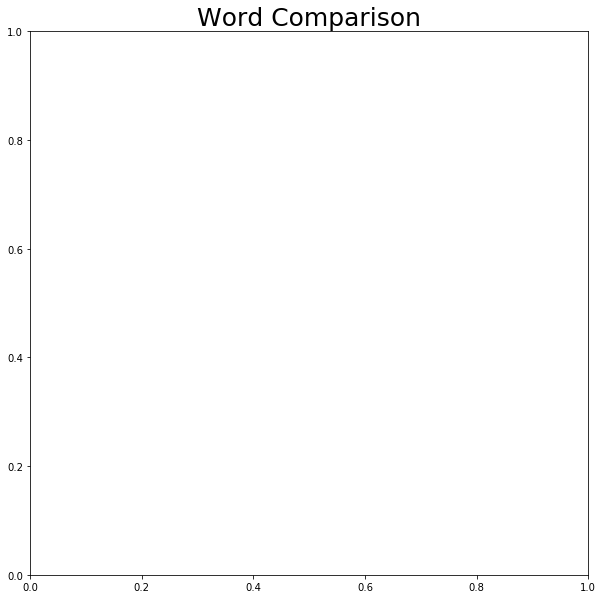

In [37]:
# Venn Diagram using the single gram dataframe results source matplotlib-venn documentation
plt.figure(figsize=(10,10))
plt.title('Word Comparison',fontsize=25)

set_a = set(top1_dadjokes_df['word'][:15])
set_b = set(top1_jokes_df['word'][:15])

venn = venn2([set_a,set_b],set_labels=['Dadjokes','Jokes'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(15)
venn.get_label_by_id('110').set_size(15)
venn.get_label_by_id('010').set_size(15)


The Venn Diagram above shows the top 15 words from both subreddits.
There are 9 common words that are shown from the venn diagram and we can see that majority of the words are of no clear meaning to our evaluation of dataset (common words that might be considered to be stop-words)

### Word Frequency Barchart

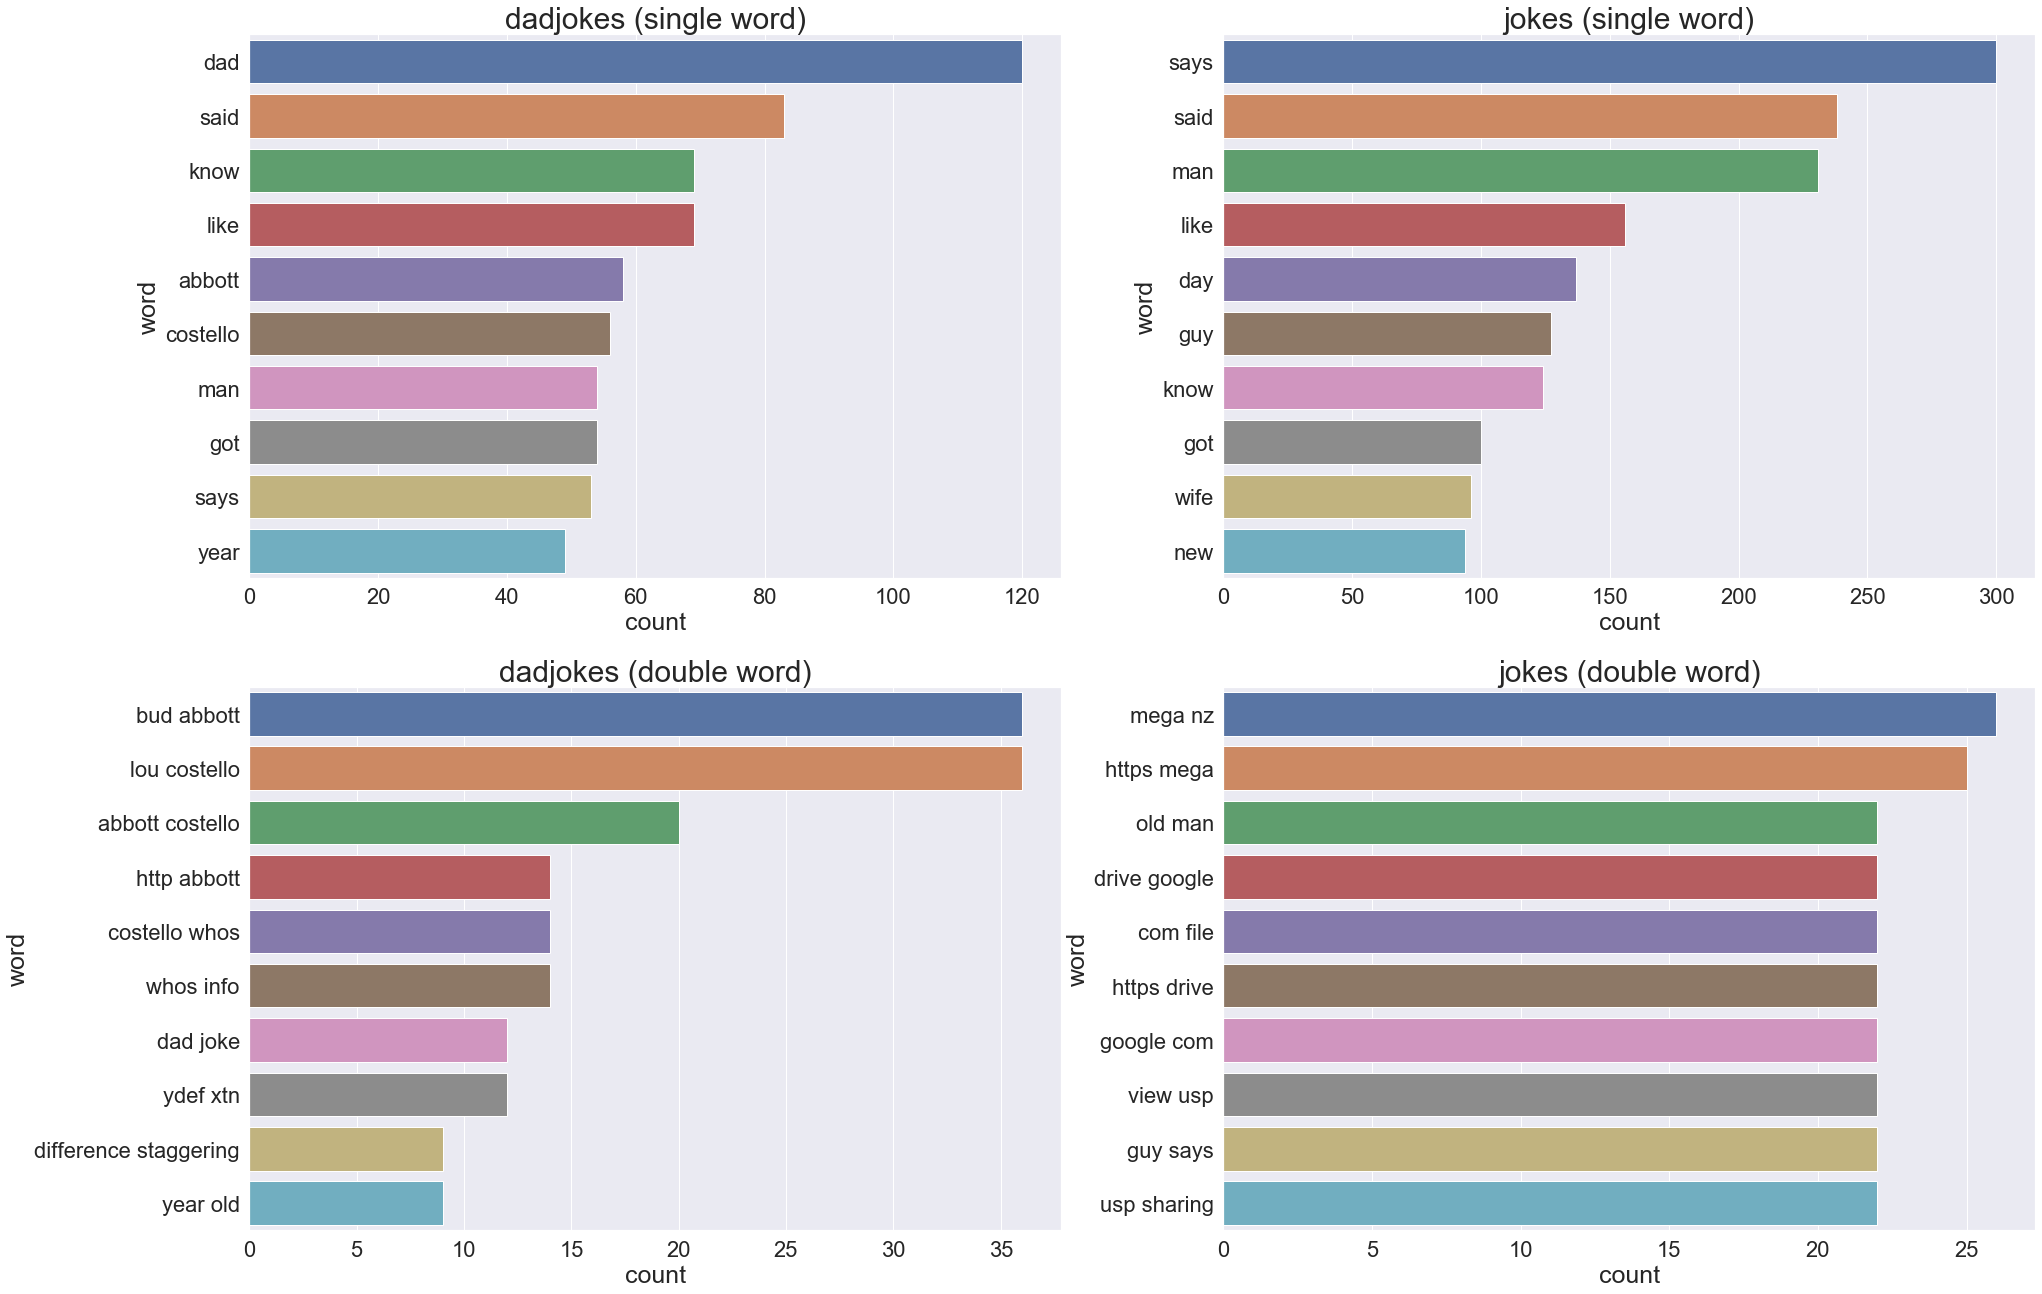

In [38]:
plt.figure(figsize = (32,22))

sns.set_style("whitegrid")
sns.set(font_scale = 2)

ax1 = plt.subplot(221)
ax1.set_xlabel('count', fontsize=25)
ax1.set_ylabel('word', fontsize=25)
ax1.set_title('dadjokes (single word)',fontsize = 30)
ax1 = sns.barplot(data=top1_dadjokes_df.head(10),x='count',y='word',orient='h')

ax2 = plt.subplot(222)
ax2.set_xlabel('count', fontsize=25)
ax2.set_ylabel('word', fontsize=25)
ax2.set_title('jokes (single word)', fontsize = 30)
ax2 = sns.barplot(data=top1_jokes_df.head(10),x='count',y='word',orient='h')

ax1 = plt.subplot(223)
ax1.set_xlabel('count', fontsize=25)
ax1.set_ylabel('word', fontsize=25)
ax1.set_title('dadjokes (double word)',fontsize = 30)
ax1 = sns.barplot(data=top2_dadjokes_df.head(10),x='count',y='word',orient='h')

ax2 = plt.subplot(224)
ax2.set_xlabel('count', fontsize=25)
ax2.set_ylabel('word', fontsize=25)
ax2.set_title('jokes (double word)', fontsize = 30)
ax2 = sns.barplot(data=top2_jokes_df.head(10),x='count',y='word',orient='h')


The barcharts above show the most frequent single-gram & bi-gram words that are apparent in the two subreddits 'jokes' & 'dadjokes'.  We can observe that a lot of the words that are commonly used are words that hold no particular value (they are all commonly used words with no specific ties to a topic).  We can also notice that "lou costello" & "bud abbott" pop up often on the dadjokes side (they are comedians from the 1930s ~ 1950s)

# Modeling

### Features

In [39]:
X = query_all['cleaned_words']
y = query_all['subreddit']

This lemmatized wordlist will be stored in a new column 'lemmatized' for later use in the Multinomial NB model.

### Train Test Split

In [40]:
#train test split on the combined data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)


In [41]:
query_all['lemmatized'] = lemmatize(query_all['cleaned_words'])

In [42]:
print(X_train.shape)
print(X_test.shape)

(3335,)
(1644,)


### Baseline Accuracy

In [43]:
#baseline accuracy
print(y_test.value_counts(normalize=True))

dadjokes    0.51764
Jokes       0.48236
Name: subreddit, dtype: float64


Our baseline predicts that our a joke post selected at random has a 52% to be dadjokes which we will compare to our model to see if we can outperform.

# Logistic Regression (CountVectorizer)

### CountVectorizer : n_gram = (1,2)

In [44]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words = 'english', ngram_range=(1,2))

# Fit the vectorizer on our corpus
cvec.fit(X_train, y_train)

#transform the corpus
X_train_cvec = cvec.transform(X_train)

X_train_cvec = pd.DataFrame(X_train_cvec.toarray(),
                         columns=cvec.get_feature_names())

#transform the test corpus

X_test_cvec = cvec.transform(X_test)

X_test_cvec = pd.DataFrame(X_test_cvec.toarray(),
                         columns=cvec.get_feature_names())

In [45]:
# Fit logistic regression on cvec data
logreg_cvec = LogisticRegression()
logreg_cvec.fit(X_train_cvec, y_train)

C:\Users\YOU-Family\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
logreg_cvec.score(X_train_cvec, y_train)

0.8827586206896552

In [47]:
logreg_cvec.score(X_test_cvec, y_test)

0.5851581508515815

Our first iteration of Logstic Regression model using CountVectorizer gives us a training score of 89% and testing score of 58%.  The training score is decent which is based on "known" data however, when our model is introduced to a dataset "unknown" (testing dataset) it did not perform too well.  Yes, our model performed better than the baseline score of 52% but it seems that both of these scores are not good indicators of an "exemplary" model.

# Logistic Regression (TfidfVectorizer)

In [48]:
# Instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2))

# Fit the vectorizer on our corpus
tvec.fit(X_train, y_train)

#transform the corpus
X_train_tvec = tvec.transform(X_train)

X_train_tvec = pd.DataFrame(X_train_tvec.toarray(),
                         columns=tvec.get_feature_names())

#transform the test corpus

X_test_tvec = tvec.transform(X_test)

X_test_tvec = pd.DataFrame(X_test_tvec.toarray(),
                         columns=tvec.get_feature_names())

In [49]:
# Fit logistic regression on tvec data
logreg_tvec = LogisticRegression()
logreg_tvec.fit(X_train_tvec, y_train)

C:\Users\YOU-Family\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
logreg_tvec.score(X_train_tvec, y_train)

0.870464767616192

In [51]:
logreg_tvec.score(X_test_tvec, y_test)

0.5912408759124088

# GridSearch & Pipeline 

In [52]:
# Setting a pipeline for cvec, tvec

pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg_cvec', LogisticRegression(solver = 'liblinear'))
])

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg_tvec', LogisticRegression(solver = 'liblinear'))
])

In [53]:
#Estimate how your model will perform on unseen data
print(f'Cross Val Score : {cross_val_score(pipe_cvec, X_train, y_train, cv=3).mean()}') 

# Fit your model
pipe_cvec.fit(X_train, y_train)

# Training score
print(f'cvec Pipeline score (train) : {pipe_cvec.score(X_train, y_train)}')

# Test score
print(f'cvec Pipeline score (test) : {pipe_cvec.score(X_test, y_test)}')

Cross Val Score : 0.5673173432451158
cvec Pipeline score (train) : 0.8563718140929535
cvec Pipeline score (test) : 0.5802919708029197


In [54]:
pipe_params_cvec = {
    'cvec__max_features': [100, 500, 1000, 2000, 5000],
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)]
}

pipe_params_tvec = {
    'tvec__max_features': [100, 500, 1000, 2000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [55]:
# Instantiate GridSearchCV.

#cvec
gs_cvec = GridSearchCV(pipe_cvec,
                  param_grid=pipe_params_cvec, 
                  cv=5) # 5-fold cross-validation.

#tvec
gs_tvec = GridSearchCV(pipe_tvec, 
                  param_grid=pipe_params_tvec,
                  cv=5) # 5-fold cross-validation.

In [56]:
gs_cvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [57]:
#Save best model
gs_model_cvec = gs_cvec.best_estimator_
# Score model on training set.
gs_train_score_cvec = gs_model_cvec.score(X_train, y_train)
gs_test_score_cvec = gs_model_cvec.score(X_test, y_test)

print(f'gs train score cvec :  {gs_train_score_cvec}')
print(f'gs test score cvec :  {gs_test_score_cvec}')

gs train score cvec :  0.7916041979010495
gs test score cvec :  0.5699513381995134


## Confusion Matrix (cvec pipeline)

In [58]:
y_pred_cvec = gs_model_cvec.predict(X_test)

In [59]:
mnb_matrix_cvec = confusion_matrix(y_test,y_pred_cvec)

In [60]:
# Create dataframe for the confusion matrix
mnb_matrix_df = pd.DataFrame(mnb_matrix_cvec, 
                         columns = ['Predicted Dadjokes', 'Predicted Jokes'], 
                         index = ['Actual Dadjokes', 'Actual Jokes'])
mnb_matrix_df

,Predicted Dadjokes,Predicted Jokes
Actual Dadjokes,328,465
Actual Jokes,242,609


In [61]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [62]:
#Save best model
gs_model_tvec = gs_tvec.best_estimator_
# Score model on training set.
gs_train_score_tvec = gs_model_tvec.score(X_train, y_train)
gs_test_score_tvec = gs_model_tvec.score(X_test, y_test)

print(f'gs train score cvec :  {gs_train_score_tvec}')
print(f'gs test score cvec :  {gs_test_score_tvec}')

gs train score cvec :  0.7778110944527736
gs test score cvec :  0.5736009732360098


## Confusion Matrix (tvec pipeline)

In [63]:
y_pred = gs_model_tvec.predict(X_test)

In [64]:
mnb_matrix_tvec = confusion_matrix(y_test,y_pred)

In [65]:
# Create dataframe for the confusion matrix
mnb_matrix_df = pd.DataFrame(mnb_matrix_tvec, 
                         columns = ['Predicted Dadjokes', 'Predicted Jokes'], 
                         index = ['Actual Dadjokes', 'Actual Jokes'])
mnb_matrix_df

,Predicted Dadjokes,Predicted Jokes
Actual Dadjokes,383,410
Actual Jokes,291,560


# Multinomial Naive Bayes

In [66]:
X = query_all['lemmatized']
y = query_all['subreddit']

In [67]:
mnb = MultinomialNB()
mnb.fit(X_train_cvec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [68]:
# Multinomial Train score
mnb.score(X_train_cvec, y_train)

0.8569715142428785

In [69]:
# Multinomial Test score
mnb.score(X_test_cvec, y_test)

0.5742092457420924

## Confusion Matrix (mnb)

In [70]:
y_pred = mnb.predict(X_test_cvec)

In [71]:
mnb_matrix = confusion_matrix(y_test,y_pred)

In [72]:
# Create dataframe for the confusion matrix
mnb_matrix_df = pd.DataFrame(mnb_matrix, 
                         columns = ['Predicted Dadjokes', 'Predicted Jokes'], 
                         index = ['Actual Dadjokes', 'Actual Jokes'])
mnb_matrix_df

,Predicted Dadjokes,Predicted Jokes
Actual Dadjokes,635,158
Actual Jokes,542,309


## Model Evaluation


### Logistic Regression Eval

In [73]:
# Evaluate logistic regression.
print(f'CountVectorizer Training Score: {logreg_cvec.score(X_train_cvec, y_train)}')
print(f'CountVectorizer Testing Score: {logreg_cvec.score(X_test_cvec, y_test)}')
print(f'TfidfVectorizer Training Score: {logreg_tvec.score(X_train_tvec, y_train)}')
print(f'TfidfVectorizer Testing Score: {logreg_tvec.score(X_test_tvec, y_test)}')

CountVectorizer Training Score: 0.8827586206896552
CountVectorizer Testing Score: 0.5851581508515815
TfidfVectorizer Training Score: 0.870464767616192
TfidfVectorizer Testing Score: 0.5912408759124088


Our first iteration of Logistic Regression model using CountVectorizer gives us a training score of 89% and testing score of 58%.  The training score is decent which is based on "known" data however, when our model is introduced to a dataset "unknown" (testing dataset) it did not perform too well.  Yes, our model performed better than the baseline score of 52% but it seems that both of these scores are not good indicators of an "exemplary" model.

Our second iteration of Logistic Regression model using TfidfVectorizer gives us a training score of 88% and testing score of 57%.  This shows that our second interation of Logstic Regression performs slightly worse on both the training and testing dataset (by a margin).

### Multinomial Naive Bayes Eval

In [74]:
# Multinomial Train score
print(f'Multinomial Naive Bayes Train Score: {mnb.score(X_train_cvec, y_train)}')
print(f'Multinomial Naive Bayes Test Score: {mnb.score(X_test_cvec, y_test)}')

Multinomial Naive Bayes Train Score: 0.8569715142428785
Multinomial Naive Bayes Test Score: 0.5742092457420924


Our multinomial naive bayes modeling technique yielded a train/test score of 87%/56% respectively.  We used a multinomial naive bayes modeling technique based on the assumption that there is a conditional independence between every pair of a feature and that our variables are only of positive values (in our case the count of frequency of words).

Our results also confirm that our model did not accurately predict which subreddit a testing set 'joke' would be from comparatively to our logistic regression although it is slightly better than our baseline accuracy.

# Conclusion & Recommendation

From using our scraped data from the two subreddits r/dadjokes & r/jokes, we were able to come up with a few models that may determine whether a random post (of a joke) indeed can be classified as a 'dadjoke' or a standard 'joke'.  However, it seems that we were only able to achieve at best a 58% accuracy in determining whether a joke is from 'dadjoke'.  As we've noticed from our EDA, it seems classification of jokes is not as simple due to the nature of the content having no particular framework to base on.  Any joke can be made from any topic as long as it can be interpretted as one by the recipient human perspective.

Although our models were able to give it a shot on predicting the difference between 'dadjokes' and 'jokes', we believe that there are too many limitations that can sway our results.  One of the limitations we found is that some joke posts are conversational dialogues such as "Lou Costello : hello, Bud Abbot : hey" and so forth which would easily skew the word count versus other jokes.  This is something we can consider and improvise on our model in the future while other limitations such as "woof woof woof" (having woof x number of times) should also be considered to better improve our model.  

With all things considered, it seems that 'Jokes' are a bit of a general topic that may be hard to legitimately classify.  Using subreddits also may not be the best data source since the activity of users that contribute may not be as reliable.

### Additionally ...

It is unclear how well our model may perform given other subreddits to see whether we can determine the relations of a statement to the subreddit since the use of stopwords and tokenization methods might not align with other subreddits common terms.